In [ ]:
#from thesisfolder.knowledge_distillation_pytorch.model.net import Net
#from thesisfolder.knowledge_distillation_pytorch.model.resnet import ResNet, ResNet18
import torchvision
from typing import Any, Callable, Optional, Tuple
from PIL import Image
from torchvision.datasets.cifar import CIFAR10
from torchvision import transforms
#from torch.utils.data import Subset, DataLoader
from thesisfolder.knowledge_distillation_pytorch.model.resnext import CifarResNeXt
from thesisfolder.knowledge_distillation_pytorch.model import data_loader
from thesisfolder.knowledge_distillation_pytorch.model.data_loader import fetch_dataloader, fetch_subset_dataloader
#from thesisfolder.methods import DotDict, load_checkpoint, accuracy, posteval, visual_heatmap_compare, heatmap, annotate_heatmap, KD_diss_compare_to_reference, multilayer_batch_overlay
from thesisfolder.methods import get_layer_strings, multilayer_batch_overlay, MSEloss, heatmap, annotate_heatmap, DotDict, apply_variable_gaussian_blur, camblur_CIFAR10, blurmask, tensorblurmask
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import wandb
#from thesisfolder.pytorch_grad_cam.pytorch_grad_cam.grad_cam import GradCAM
from thesisfolder.pytorch_grad_cam.pytorch_grad_cam.utils.image import show_cam_on_image
from torch import tensor
from torch.autograd import Variable
import pickle
import cv2
#import torch.nn.functional as F
#from thesisfolder.pytorch_grad_cam.pytorch_grad_cam import grad_cam 
import os
import torch
#from torch.nn import init
import torch.nn as nn
import random
from torch.nn import Module
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print("Available device = ", device)

: 

In [2]:
     
simpnetparams ={
    "model_version": "base_cnn",
    "subset_percent": 1.,
    "augmentation": "no",
    "teacher": "resnext29",
    "alpha": 0.9,
    "temperature": 20,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "num_epochs": 100,
    "dropout_rate": 0.5, 
    "num_channels": 32,
    "save_summary_steps": 100,
    "num_workers": 4,
    "cam_layer": 3
}
params = simpnetparams
params = DotDict(simpnetparams)
params.cuda = torch.cuda.is_available()

random.seed(230)
torch.manual_seed(230)

#train_dl = fetch_dataloader('train', params)

In [3]:
import pickle
with open('/home/smartinez/thesisfolder/train_dl_cam_dict_resnext_teach_only.pkl', 'rb') as file:
    heatdict = pickle.load(file)

In [33]:
from torchvision.transforms import v2
a = torch.randint(0,10,(2,2),dtype=torch.int)
train_transformer = v2.Compose([
        v2.ConvertDtype(dtype=torch.float)])
print(a)
train_transformer(a)

tensor([[6, 0],
        [5, 7]], dtype=torch.int32)


tensor([[2.7940e-09, 0.0000e+00],
        [2.3283e-09, 3.2596e-09]])

In [26]:
trainset = camblur_CIFAR10(root='/home/smartinez/thesisfolder/knowledge_distillation_pytorch/data-cifar10', train=True,
        download=False, transform=train_transformer, cam_layer=params.cam_layer)
train_dl = torch.utils.data.DataLoader(trainset, batch_size=params.batch_size,
        shuffle=True, num_workers=params.num_workers, pin_memory=False)


In [4]:
def newblurmask(image, heatmap, kernel=5, sigma=3):
  if isinstance(image,torch.Tensor) or isinstance(image, Image.Image):
    if isinstance(image, torch.Tensor):                                                 #if image.shape[0] == 3:
        converted_image = np.transpose(image.numpy(), (1, 2, 0))
        print(f"converting from tensor") 
    else:
      print(f"converting from pil")
      converted_image = np.asarray(image)
          #  print(f"image shape {converted_image.shape}")
            #print(f"image {image}")
          #  print(f"heatmap {heatmap}")
  
   
  else:
    converted_image = image 
  print(f"image type {converted_image.dtype}, image shape {converted_image.shape}")
  blurred_image = cv2.GaussianBlur(converted_image, (kernel, kernel),sigmaX=sigma) # Blur it as intense as you would like to have your maxmum intensity
  print(f"blurred image shape {blurred_image.shape}")
  blended_image = np.zeros_like(converted_image) # We want an zero-array in the shape of the original image
  print(f"desired blended image shape {blended_image.shape} ")
  #Now we pblend in the blurred image with the original image based on the heatmap values
#  for i in range(image.shape[0]):
  #     for j in range(image.shape[1]):
  #        blend_ratio = heatmap[i,j] # This gives me the intensity value of the blurring between 0 and 1
    #       blended_image[i,j] = image[i,j] * blend_ratio + blurred_image[i,j] * 1- blend_ratio
  blend_ratio = np.repeat(heatmap[:,:,None], 3, axis=-1)
  print(f"blend_ratio matrix shape {blend_ratio.shape}")
  if blend_ratio.shape != converted_image.shape:
    print("transposing blend_ratio matrix")
    blend_ratio = np.transpose(blend_ratio,(2,0,1))
  blended_image = (blend_ratio * converted_image + (1-blend_ratio)*blurred_image)
  return blended_image       

In [248]:

class newblur_CIFAR10(CIFAR10):
    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
        cam_layer: int = -1,
        heatdictpath: str = '/home/smartinez/thesisfolder/train_dl_cam_dict_resnext_teach_only.pkl'
    ):
        super().__init__(root, train, transform, target_transform, download)
        self.cam_layer = cam_layer
        self.heatdictpath = heatdictpath
        with open(self.heatdictpath, 'rb') as file:
            self.heatdict = pickle.load(file)
        
    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        
        img = Image.fromarray(img)
        img = newblurmask(img, self.heatdict[index][(self.cam_layer)-1])   
        if not isinstance(img, Image.Image):
          #  print("not of type image")
            if isinstance(img, np.ndarray):
                
           #     print("of type numpy array")
                if img.dtype == np.float32 :
                    print (f"datatype of array {img.dtype}")
                    print(img)
                    if img.max() <= 1:
                        
                        img = Image.fromarray((img * 255).astype(np.uint8))
                    else:
                        img = Image.fromarray((img).astype(np.uint8))
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        #print(f"index {index}")
        #print(f"shape of heatdict[index] {self.heatdict[index].shape}")
       # img = blurmask(img, self.heatdict[index][(self.cam_layer)-1])    

        return img, target



In [249]:

def oldblurmask(image, heatmap, kernel=5, sigma=3):
  if isinstance(image,torch.Tensor) or isinstance(image, Image.Image):
    if isinstance(image, torch.Tensor):                                                 #if image.shape[0] == 3:
      converted_image = np.transpose(image.numpy(), (1, 2, 0))
        #print(f"converting from tensor") 
    else:
           # print(f"converting from pil")
      converted_image = np.asarray(image)
          #  print(f"image shape {converted_image.shape}")
            #print(f"image {image}")
          #  print(f"heatmap {heatmap}")
   # print(f"image type {image.dtype}")
  else:
    converted_image = image 
  blurred_image = cv2.GaussianBlur(converted_image, (kernel, kernel),sigmaX=sigma) # Blur it as intense as you would like to have your maxmum intensity

  blended_image = np.zeros_like(image) # We want an zero-array in the shape of the original image

  #Now we pblend in the blurred image with the original image based on the heatmap values
#  for i in range(image.shape[0]):
  #     for j in range(image.shape[1]):
  #        blend_ratio = heatmap[i,j] # This gives me the intensity value of the blurring between 0 and 1
    #       blended_image[i,j] = image[i,j] * blend_ratio + blurred_image[i,j] * 1- blend_ratio
  blend_ratio = np.repeat(heatmap[:,:,None], 3, axis=-1)
  blended_image = (blend_ratio * image + (1-blend_ratio)*blurred_image)
  return blended_image        

In [250]:
train_vanilla_transformer = transforms.Compose([
    transforms.ToTensor()])#,
  #  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
denormalised_trainset = torchvision.datasets.CIFAR10(root='/home/smartinez/thesisfolder/knowledge_distillation_pytorch/data-cifar10', train=True,
        download=True, transform=train_transformer)

train_transformer = transforms.Compose([
     transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip()  # randomly flip image horizontally
        ])
        
trainset = torchvision.datasets.CIFAR10(root='/home/smartinez/thesisfolder/knowledge_distillation_pytorch/data-cifar10', train=True,
        download=True, transform=train_transformer)

Files already downloaded and verified
Files already downloaded and verified


In [251]:
newblurset = newblur_CIFAR10(root='/home/smartinez/thesisfolder/knowledge_distillation_pytorch/data-cifar10', train=True,
        download=True, transform=train_transformer, cam_layer=params.cam_layer)

Files already downloaded and verified


In [22]:
blurset = camblur_CIFAR10(root='/home/smartinez/thesisfolder/knowledge_distillation_pytorch/data-cifar10', train=True,
        download=True, transform=train_transformer, cam_layer=params.cam_layer)
sourceset = CIFAR10(root='/home/smartinez/thesisfolder/knowledge_distillation_pytorch/data-cifar10', train=True,
        download=True, transform=train_transformer)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
image1, label1 = trainset[0]
print(image1.max())

tensor(1.1688e-07, device='cuda:0')


In [253]:
newimg1, newlabel1 = newblurset[0]

converting from pil
image type uint8, image shape (32, 32, 3)
blurred image shape (32, 32, 3)
desired blended image shape (32, 32, 3) 
blend_ratio matrix shape (32, 32, 3)
datatype of array float32
[[[ 27.913578  22.435463  17.783384]
  [ 32.63786   25.275719  18.623642]
  [ 48.13331   33.99983   22.466415]
  ...
  [131.4855    97.62935   66.755226]
  [128.22762   95.28452   64.3604  ]
  [127.199165  93.29401   63.379368]]

 [[ 29.18818   22.826038  16.231949]
  [ 33.912464  24.492334  16.01422 ]
  [ 49.733723  34.13365   19.60024 ]
  ...
  [130.85614   95.85615   63.838165]
  [127.91464   93.89567   61.886185]
  [125.96206   92.94309   61.952576]]

 [[ 40.97488   28.698494  18.180904]
  [ 46.07036   31.432167  17.854275]
  [ 62.047264  40.97921   22.91116 ]
  ...
  [122.814804  88.814804  56.740734]
  [119.024635  85.95072   54.876812]
  [116.8029    84.704346  54.679707]]

 ...

 [[189.71225  146.89969   52.686916]
  [188.48734  145.2999    50.36272 ]
  [185.5341   145.65733   47.096

In [254]:
srcimg1, srclabel1 = sourceset[0]
srcimg2, srclabel2 = sourceset[1]
np_src1 = np.array(srcimg1)
np_src2 = np.array(srcimg2)
print(f"src image 1 shape before transposing{np_src1.shape}")
print(np_src2.shape)
np_src1 = np.transpose(np_src1,(2,0,1))
np_src2 = np.transpose(np_src2,(2,0,1))
print(f"shape of np source image 1{np_src1.shape}")
print(f"same but for the second image{np_src2.shape}")
stackarray = np.stack((np_src1, np_src2))
print(f"shape of the two images stacked {stackarray.shape}")

src image 1 shape before transposing(32, 32, 3)
(32, 32, 3)
shape of np source image 1(3, 32, 32)
same but for the second image(3, 32, 32)
shape of the two images stacked (2, 3, 32, 32)


In [255]:
resnext29_visual = multilayer_batch_overlay(stackarray, np.array([heatdict[0],heatdict[1]]), use_rgb=True)

In [256]:
blurimg1, blurabel1 = blurset[0]
np.array(blurimg1).shape

(32, 32, 3)

In [12]:
image1.max()

tensor(-1.7107, device='cuda:0')

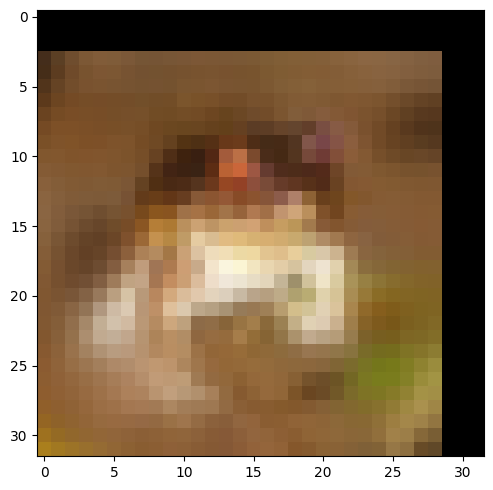

In [20]:


# Create a figure and axis
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

plt.imshow(np.array(image1.cpu()).transpose(1,2,0))

#for i in range(3):
# Plot each image
   # axs[i].imshow(image1)
  #$#  axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

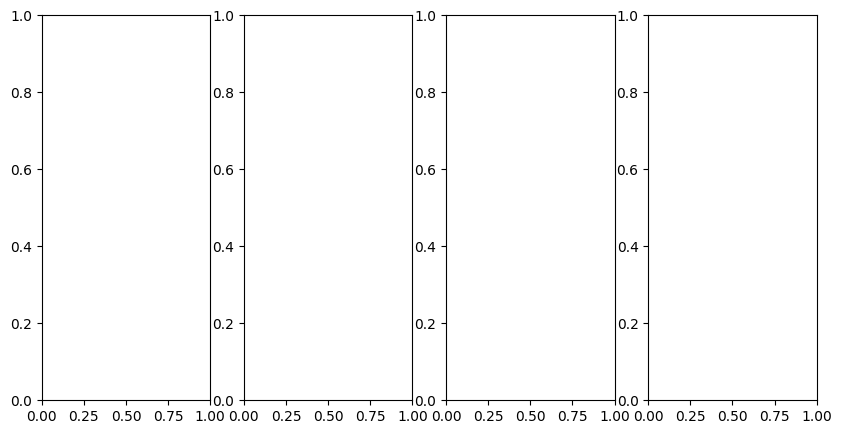

In [7]:


# Create a figure and axis
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

axs[0].imshow(np.array(srcimg1))
axs[1].imshow(resnext29_visual[0][0].astype(int).transpose(1, 2, 0), interpolation='bilinear')
axs[2].imshow(resnext29_visual[0][1].astype(int).transpose(1, 2, 0), interpolation='bilinear')
axs[3].imshow(resnext29_visual[0][2].astype(int).transpose(1, 2, 0), interpolation='bilinear')
#for i in range(3):
# Plot each image
   # axs[i].imshow(image1)
  #$#  axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [258]:
imagerino, labelino = trainset[0]
denormalised_img, label = denormalised_trainset[0]
denormalised_img2, label2 = denormalised_trainset[1]

In [259]:
np.transpose(np.array(denormalised_img),(2,0,1)).shape

(3, 32, 32)

In [260]:
denormalised_imagerino_np = (np.array(denormalised_img))  # Tra
blurred_img = blurmask(srcimg1, heatdict[0][params.cam_layer -1]) # srcimg1, srclabel1 = sourceset[0]
tensorblur = blurmask(denormalised_imagerino_np, heatdict[0][params.cam_layer -1])


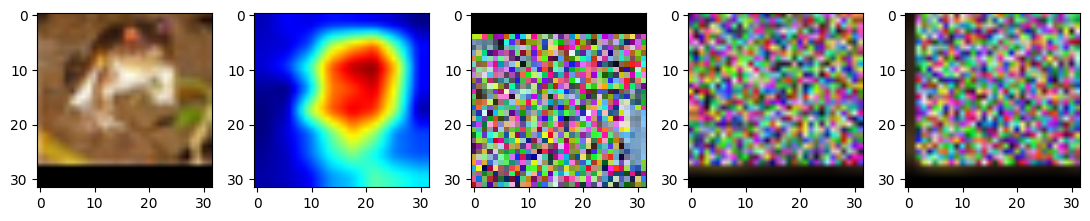

In [261]:

#print(blurimg1.shape)
# Create a figure and axis
fig, axs = plt.subplots(1, 5, figsize=(11, 9))

axs[0].imshow(np.array(srcimg1), interpolation= 'bilinear')
axs[1].imshow(resnext29_visual[0][2].astype(int).transpose(1, 2, 0),interpolation = "bilinear")
axs[2].imshow(np.array(blurimg1).astype(int))
axs[3].imshow(np.asarray(blurred_img).astype(int), interpolation= 'bilinear') #blurred_img = blurmask(srcimg1, heatdict[0][2]) # srcimg1, srclabel1 = sourceset[0]
axs[4].imshow(tensorblur, interpolation= 'bilinear')
#for i in range(3):
# Plot each image
   # axs[i].imshow(image1)
  #$#  axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


    
    

In [262]:
denormalised_imagerino_np = denormalised_img # Tra
blurred_img = newblurmask(srcimg1, heatdict[0][params.cam_layer -1]) # srcimg1, srclabel1 = sourceset[0]
tensorblur = newblurmask(denormalised_imagerino_np, heatdict[0][params.cam_layer -1])

converting from pil
image type uint8, image shape (32, 32, 3)
blurred image shape (32, 32, 3)
desired blended image shape (32, 32, 3) 
blend_ratio matrix shape (32, 32, 3)
converting from pil
image type uint8, image shape (32, 32, 3)
blurred image shape (32, 32, 3)
desired blended image shape (32, 32, 3) 
blend_ratio matrix shape (32, 32, 3)


In [263]:
tensorblur.max()

253.27971

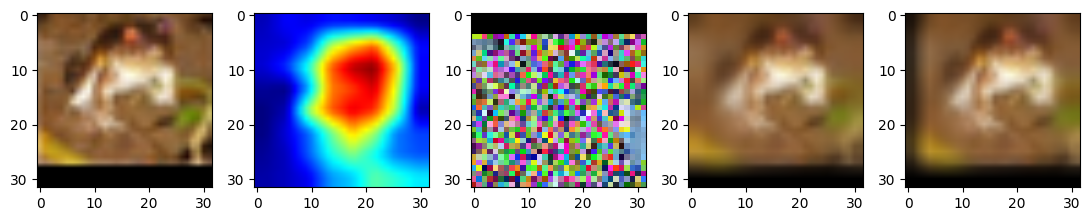

In [264]:

#print(blurimg1.shape)
# Create a figure and axis
fig, axs = plt.subplots(1, 5, figsize=(11, 9))

axs[0].imshow(np.array(srcimg1), interpolation= 'bilinear')
axs[1].imshow(resnext29_visual[0][2].astype(int).transpose(1, 2, 0),interpolation = "bilinear")
axs[2].imshow(np.array(blurimg1).astype(int))
axs[3].imshow(np.asarray(blurred_img).astype(int), interpolation= 'bilinear') #blurred_img = blurmask(srcimg1, heatdict[0][2]) # srcimg1, srclabel1 = sourceset[0]
axs[4].imshow(tensorblur.astype(int), interpolation= 'bilinear')
#for i in range(3):
# Plot each image
   # axs[i].imshow(image1)
  #$#  axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()



In [265]:
denormalised_imagerino_np = np.transpose(denormalised_img.numpy(), (1, 2, 0))  # Tra
blurred_img = oldblurmask(srcimg1, heatdict[0][params.cam_layer -1]) # srcimg1, srclabel1 = sourceset[0]
tensorblur = oldblurmask(denormalised_imagerino_np, heatdict[0][params.cam_layer -1])

AttributeError: 'Image' object has no attribute 'numpy'

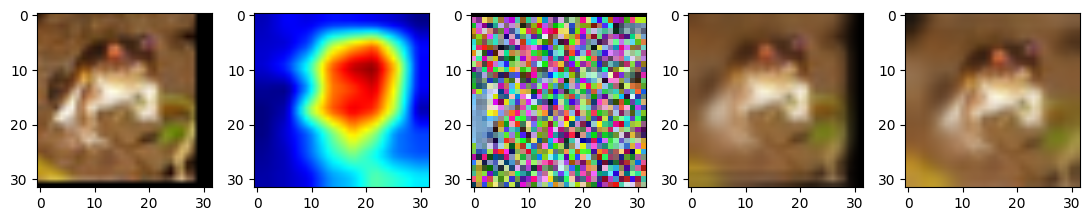

In [ ]:

#print(blurimg1.shape)
# Create a figure and axis
fig, axs = plt.subplots(1, 5, figsize=(11, 9))

axs[0].imshow(np.array(srcimg1), interpolation= 'bilinear')
axs[1].imshow(resnext29_visual[0][2].astype(int).transpose(1, 2, 0),interpolation = "bilinear")
axs[2].imshow(np.array(blurimg1).astype(int))
axs[3].imshow(np.asarray(blurred_img).astype(int), interpolation= 'bilinear') #blurred_img = blurmask(srcimg1, heatdict[0][2]) # srcimg1, srclabel1 = sourceset[0]
axs[4].imshow(tensorblur, interpolation= 'bilinear')
#for i in range(3):
# Plot each image
   # axs[i].imshow(image1)
  #$#  axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()



In [ ]:
denormalised_img, label = denormalised_trainset[0]
denormalised_img2, label2 = denormalised_trainset[1]

In [268]:
newimg1_np = np.asarray(newimg1)

In [ ]:
newimg1_np.shape

(32, 32, 3)

In [266]:
newimg1_np.max()

255

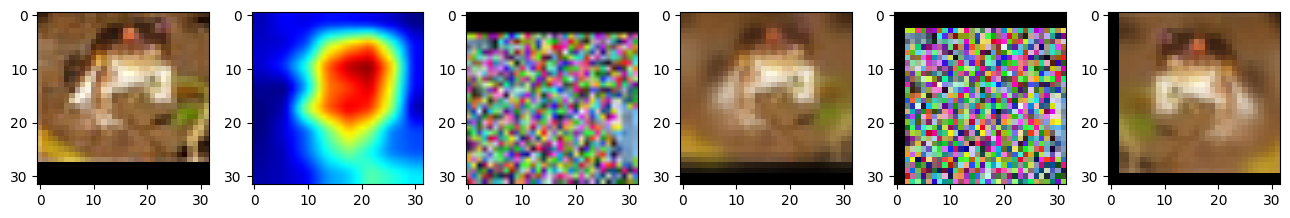

In [267]:

#print(blurimg1.shape)
# Create a figure and axis
fig, axs = plt.subplots(1, 6, figsize=(13, 9))

axs[0].imshow(np.array(srcimg1))
axs[1].imshow(np.array(resnext29_visual[0][params.cam_layer -1]).astype(int).transpose(1, 2, 0),interpolation = "bilinear")
axs[2].imshow(np.array(blurimg1).astype(int),interpolation = 'bilinear')#np.array(blurimg1))
#srcimg1, srclabel1 = sourceset[0]
#blurred_img = newblurmask(srcimg1, heatdict[0][2]) 

axs[3].imshow(np.array(blurred_img).astype(int)) #blurred_img = blurmask(srcimg1, heatdict[0][2]) # srcimg1, srclabel1 = sourceset[0]
axs[4].imshow(newimg1_np.astype(int))# tensorblur = blurmask(denormalised_imagerino_np, heatdict[0][params.cam_layer -1])
#denormalised_imagerino_np = np.transpose(denormalised_img.numpy(), (1, 2, 0))  # Tra
## srcimg1, srclabel1 = sourceset[0]

#axs[5].imshow(np.array(newimg1).astype(int).transpose(1,2,0), interpolation = 'bilinear')
axs[5].imshow(newimg1)
#axs[6].imshow(newimg1)

#for i in range(3):
# Plot each image
   # axs[i].imshow(image1)
  #$#  axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


    

In [ ]:
newimg1_np

array([[[186, 106, 143, ..., 156, 179,  74],
        [233, 135, 157, ...,  18, 101,  87],
        [ 27, 164, 169, ...,  66,  78, 121]],

       [[248,  88,  85, ...,  62, 222, 151],
        [ 63, 123, 119, ...,  11, 207, 251],
        [126, 150, 132, ..., 230, 242, 191]],

       [[ 70, 103, 142, ..., 183, 210, 110],
        [167, 130, 178, ...,  30, 235, 140],
        [ 16, 146, 181, ...,  32, 235,  42]],

       ...,

       [[130, 199, 227, ..., 192, 184, 134],
        [ 45, 101,  79, ..., 187, 146, 206],
        [141, 243, 200, ...,  42,  70,  68]],

       [[205,  18, 208, ..., 248,   9, 235],
        [ 89, 188, 150, ...,  83,  61, 112],
        [182,  43,  28, ..., 123,  88,  10]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8)

converting from pil
image type uint8, image shape (32, 32, 3)
blurred image shape (32, 32, 3)
desired blended image shape (32, 32, 3) 
blend_ratio matrix shape (32, 32, 3)


AttributeError: 'Image' object has no attribute 'numpy'

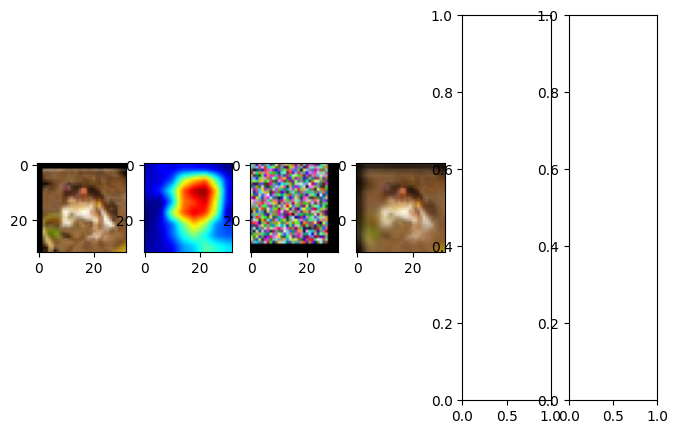

In [ ]:

#print(blurimg1.shape)
# Create a figure and axis
fig, axs = plt.subplots(1, 6, figsize=(8, 5))

axs[0].imshow(np.array(srcimg1))
axs[1].imshow(resnext29_visual[0][2].astype(int).transpose(1, 2, 0),interpolation = "bilinear")
axs[2].imshow(np.array(blurimg1))
blurred_img = newblurmask(srcimg1, heatdict[0][2])
axs[3].imshow(np.array(blurred_img).astype(int))#.astype(int),interpolation= 'bilinear')
denormalised_imagerino_np = np.transpose(denormalised_img.numpy(), (1, 2, 0))  # Transpose to (H, W, C) for Matplotlib.
tensorblur = newblurmask(denormalised_imagerino_np, heatdict[0][2])
axs[4].imshow(tensorblur)
axs[5].imshow(newimg1_np.astype(int))
#for i in range(3):
# Plot each image
   # axs[i].imshow(image1)
  #$#  axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


    
    

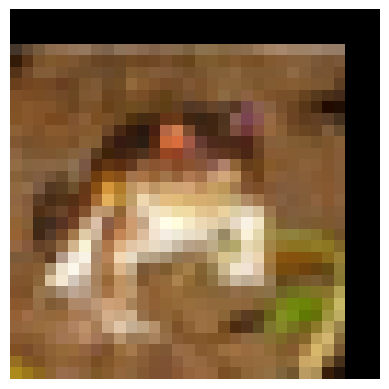

In [ ]:
imagerino_np = np.transpose(imagerino.numpy(), (1, 2, 0))  # Transpose to (H, W, C) for Matplotlib

# Plot the image
plt.imshow(imagerino_np)
plt.axis('off')  # Turn off axis
plt.show()

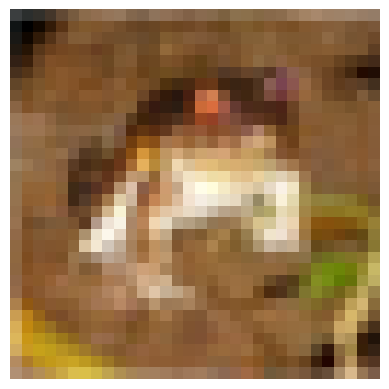

In [ ]:
denormalised_imagerino_np = np.transpose(denormalised_img.numpy(), (1, 2, 0))  # Transpose to (H, W, C) for Matplotlib

# Plot the image
plt.imshow(denormalised_imagerino_np)
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
testmap = list(heatdict.values())[:2]


In [ ]:
testmap[0][0].shape

(32, 32)

In [ ]:
denormalised_img.shape

torch.Size([3, 32, 32])

In [ ]:
testmaparray = np.array([testmap[0],testmap[1]])
testmaparray.shape

(2, 3, 32, 32)

In [ ]:
stacked_tensor = torch.stack([denormalised_img, denormalised_img2], dim=0)
stacked_tensor.shape

torch.Size([2, 3, 32, 32])

In [ ]:
resnext29_visual_tensor = multilayer_batch_overlay(stacked_tensor, np.array([testmap[0],testmap[1]]), use_rgb=True)



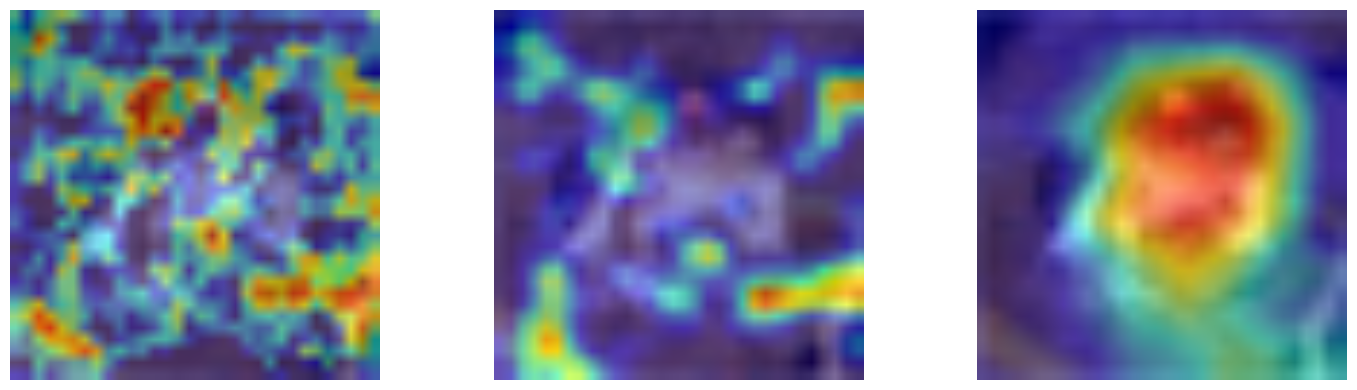

In [ ]:



# Create a figure and axis
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
# Plot each image
   # axs[i].imshow(image1)
    axs[i].imshow(resnext29_visual_tensor[0][i].astype(int).transpose(1, 2, 0), interpolation='bilinear')
    axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

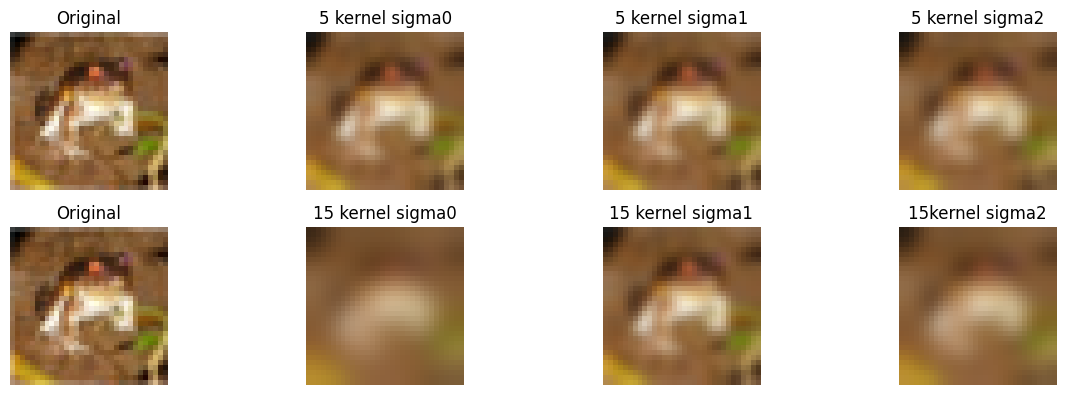

In [ ]:
# Plot the images using matplotlib
# Experiment with different kernel sizes
denormalised_imagerino_np = np.transpose(denormalised_img.numpy(), (1, 2, 0)) 
blurred_image_small_kernel_sig0 = cv2.GaussianBlur(denormalised_imagerino_np, (5, 5),sigmaX=0)
blurred_image_small_kernel_sig1 = cv2.GaussianBlur(denormalised_imagerino_np, (5, 5),sigmaX=1)
blurred_image_small_kernel_sig5 = cv2.GaussianBlur(denormalised_imagerino_np, (5, 5),sigmaX=2)
blurred_image_mid_kernel_sig0 = cv2.GaussianBlur(denormalised_imagerino_np, (15, 15),sigmaX=0)
blurred_image_mid_kernel_sig1 = cv2.GaussianBlur(denormalised_imagerino_np, (15, 15),sigmaX=1)
blurred_image_mid_kernel_sig5 = cv2.GaussianBlur(denormalised_imagerino_np, (15, 15),sigmaX=2)

plt.figure(figsize=(12, 6))

# First row
plt.subplot(3, 4, 1)
plt.imshow(denormalised_imagerino_np)
plt.title('Original')
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(blurred_image_small_kernel_sig0)
plt.title('5 kernel sigma0')
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(blurred_image_small_kernel_sig1)
plt.title('5 kernel sigma1')
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(blurred_image_small_kernel_sig5)
plt.title('5 kernel sigma2')
plt.axis('off')

# Second row
plt.subplot(3, 4, 5)
plt.imshow(denormalised_imagerino_np)
plt.title('Original')
plt.axis('off')

plt.subplot(3, 4, 6)
plt.imshow(blurred_image_mid_kernel_sig0)
plt.title('15 kernel sigma0')
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(blurred_image_mid_kernel_sig1)
plt.title('15 kernel sigma1')
plt.axis('off')

plt.subplot(3, 4, 8)
plt.imshow(blurred_image_mid_kernel_sig5)
plt.title('15kernel sigma2')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
resnext29_visual[0].shape

(3, 3, 32, 32)

In [ ]:
testmap[0].shape

(3, 32, 32)

In [ ]:
denormalised_img.numpy().shape

(3, 32, 32)

In [ ]:
testmap[0][1].shape

(32, 32)

In [ ]:
denormalised_imagerino_np.shape

(32, 32, 3)

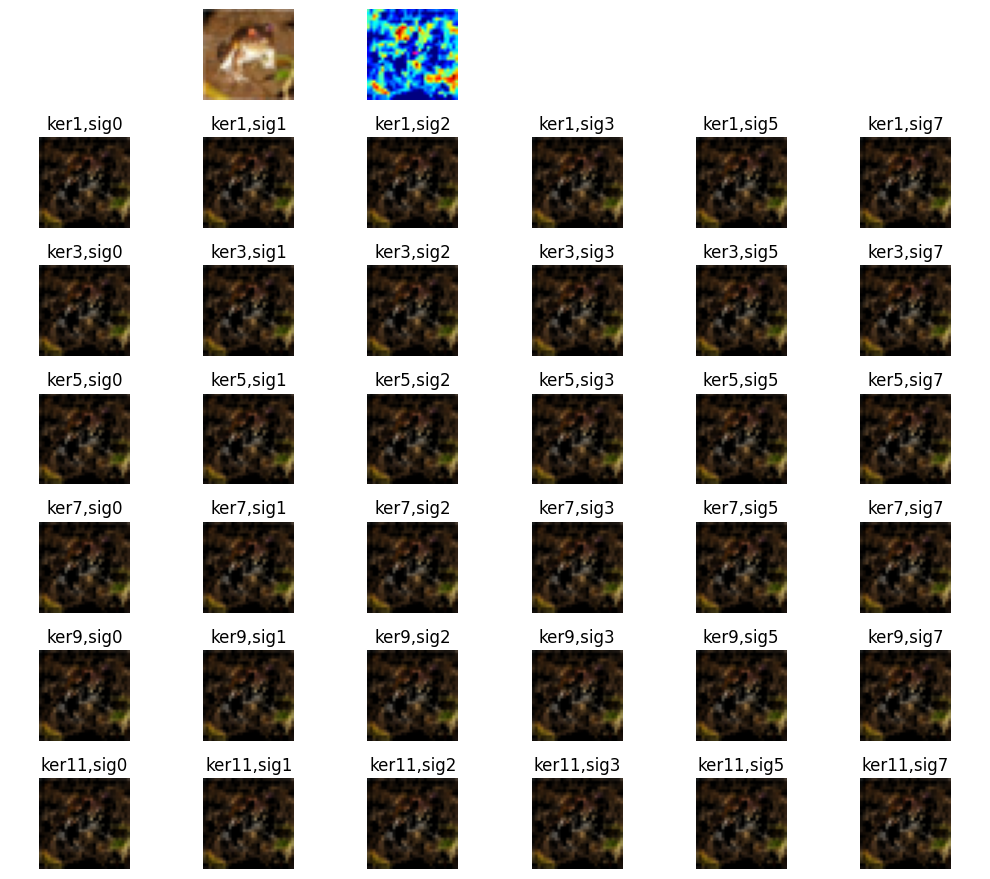

In [ ]:
# Create a figure and axis
fig, axs = plt.subplots(7, 6, figsize=(10,8.9))
denormalised_imagerino_np = np.transpose(denormalised_img.numpy(), (1, 2, 0))  # Transpose to (H, W, C) for Matplotlib
kernels =[1,3,5, 7, 9, 11]
sigmas = [0,1,2, 3, 5, 7 ]
for x in range(len(kernels)):
# Plot the image
    for i in range(len(sigmas)):
    # Plot each image
    # axs[i].imshow(image1)
        blurred_img = blurmask(denormalised_imagerino_np, testmap[0][0],kernels[x],sigmas[i])
        
        axs[x+1][i].imshow(blurred_img)
        axs[x+1][i].set_title(f"ker{kernels[x]},sig{sigmas[i]}")
    # axs[i].imshow(blurred_img.astype(int).transpose(1, 2, 0), interpolation='bilinear')
for ax in axs.ravel():
    ax.axis('off')    
     
axs[0][1].imshow(denormalised_imagerino_np)
axs[0][2].imshow(resnext29_visual[0][0].astype(int).transpose(1, 2, 0), interpolation='bilinear')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

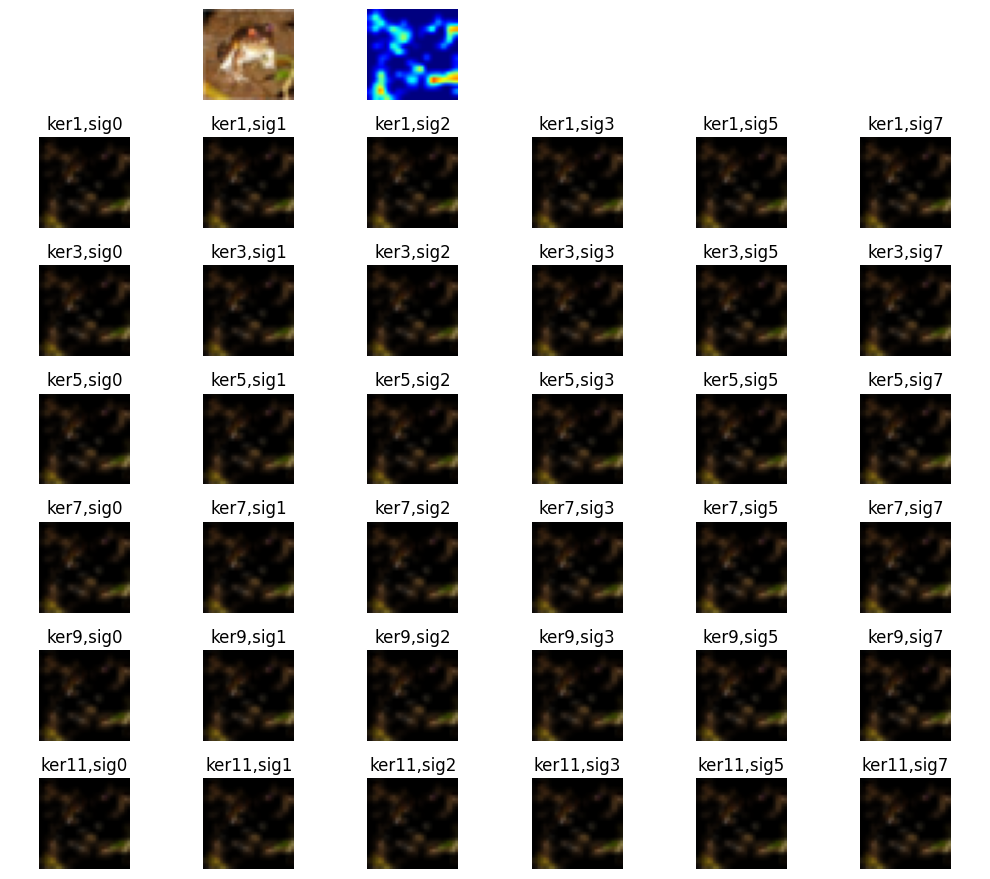

In [ ]:
# Create a figure and axis
fig, axs = plt.subplots(7, 6, figsize=(10,8.9))
denormalised_imagerino_np = np.transpose(denormalised_img.numpy(), (1, 2, 0))  # Transpose to (H, W, C) for Matplotlib
kernels = [1,3,5, 7, 9, 11]
sigmas = [0,1,2, 3, 5, 7]
for x in range(len(kernels)):
# Plot the image
    for i in range(len(sigmas)):
    # Plot each image
    # axs[i].imshow(image1)
        blurred_img = blurmask(denormalised_imagerino_np, testmap[0][1],kernels[x],sigmas[i])
        
        axs[x+1][i].imshow(blurred_img)
        axs[x+1][i].set_title(f"ker{kernels[x]},sig{sigmas[i]}")
    # axs[i].imshow(blurred_img.astype(int).transpose(1, 2, 0), interpolation='bilinear')
    
       # axs[2][i].axis('off')
        #axs[0][i].axis('off')
for ax in axs.ravel():
    ax.axis('off')        
axs[0][1].imshow(denormalised_imagerino_np)
axs[0][2].imshow(resnext29_visual[0][1].astype(int).transpose(1, 2, 0), interpolation='bilinear')
    

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

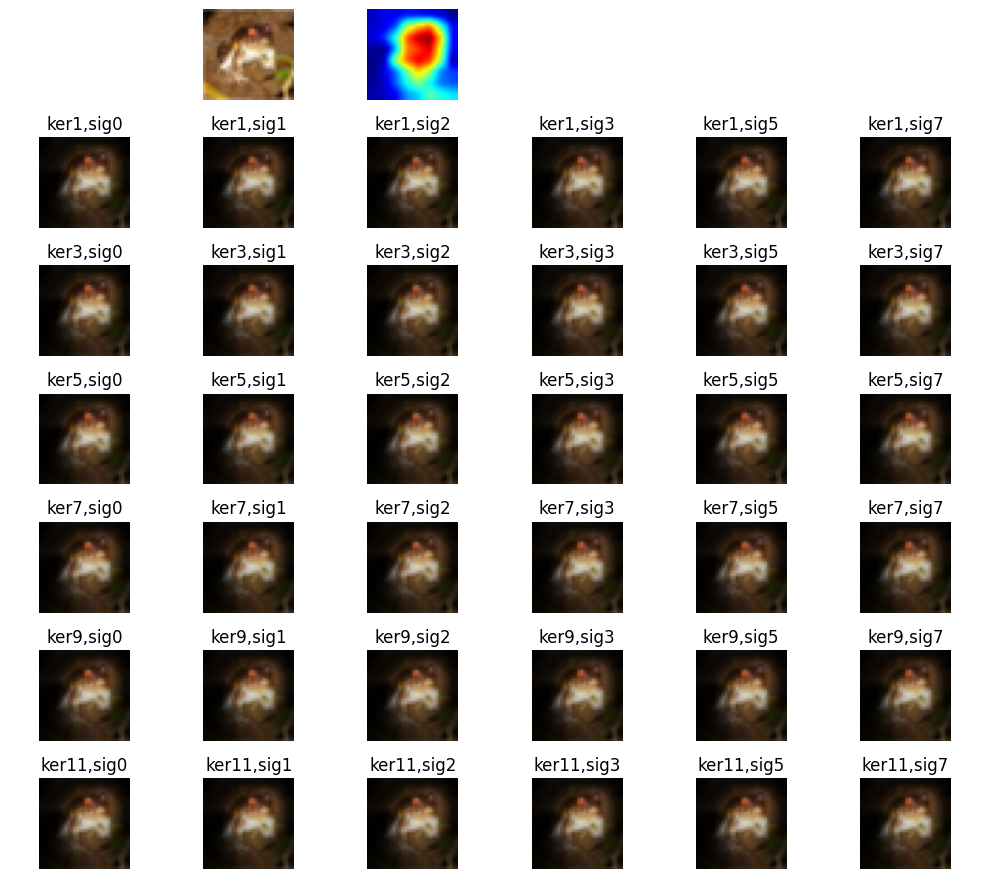

In [ ]:
# Create a figure and axis
fig, axs = plt.subplots(7, 6, figsize=(10,8.9))
denormalised_imagerino_np = np.transpose(denormalised_img.numpy(), (1, 2, 0))  # Transpose to (H, W, C) for Matplotlib
kernels = [1,3,5, 7, 9, 11]
sigmas =  [0,1, 2,  3, 5, 7]
for x in range(len(kernels)):
# Plot the image
    for i in range(len(sigmas)):
    # Plot each image
    # axs[i].imshow(image1)
        blurred_img = blurmask(denormalised_imagerino_np, testmap[0][2],kernels[x],sigmas[i])
        
        axs[x+1][i].imshow(blurred_img)
        axs[x+1][i].set_title(f"ker{kernels[x]},sig{sigmas[i]}")
    # axs[i].imshow(blurred_img.astype(int).transpose(1, 2, 0), interpolation='bilinear')
    #    axs[i][i].axis('off')
    
    
for ax in axs.ravel():
    ax.axis('off')    
        
axs[0][1].imshow(denormalised_imagerino_np)
axs[0][2].imshow(resnext29_visual[0][2].astype(int).transpose(1, 2, 0), interpolation='bilinear')
    

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

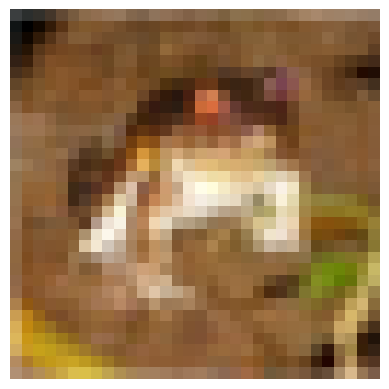

In [ ]:
denormalised_imagerino_np = np.transpose(denormalised_img.numpy(), (1, 2, 0))  # Transpose to (H, W, C) for Matplotlib

# Plot the image
plt.imshow(denormalised_imagerino_np)
plt.axis('off')  # Turn off axis
plt.show()

NameError: name 'resnet18_layers' is not defined

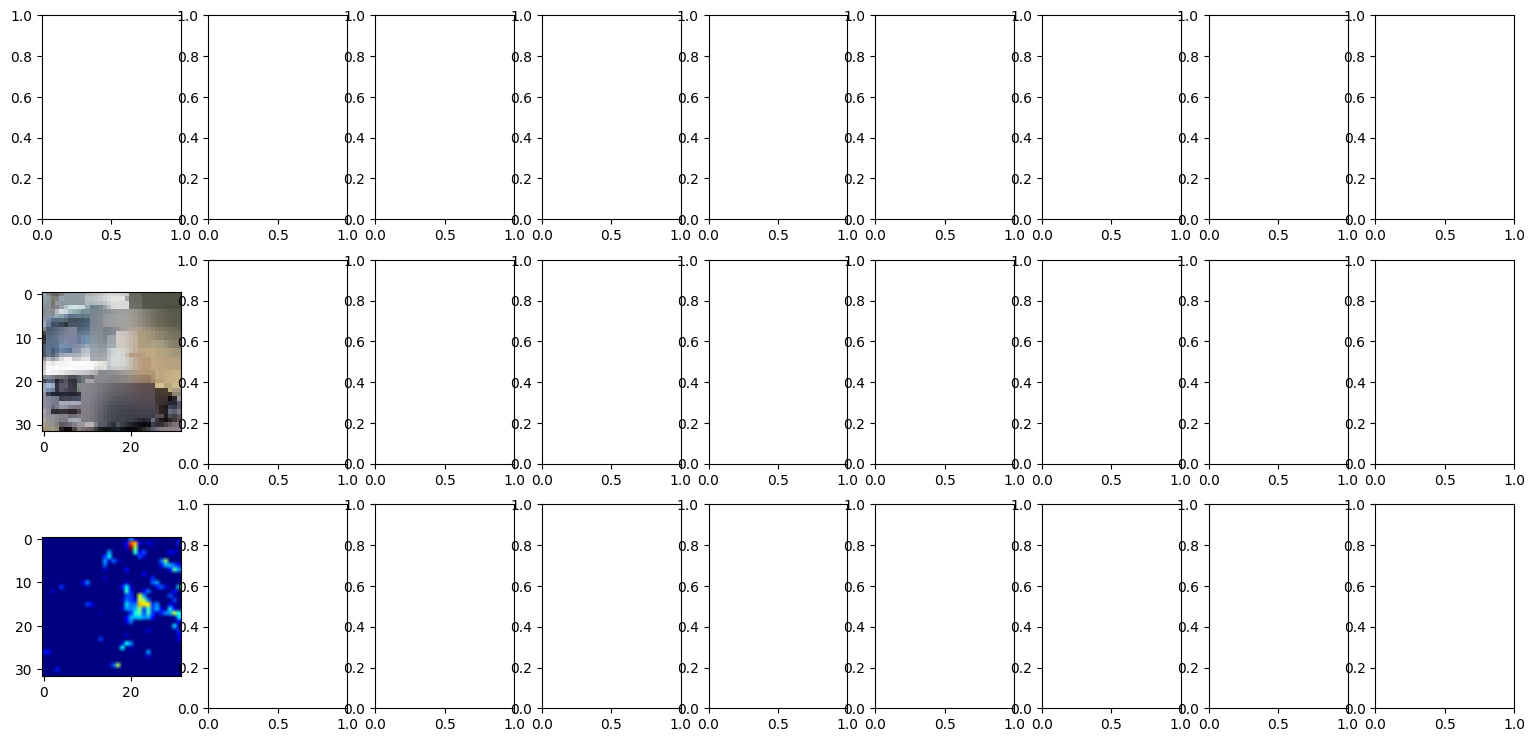

In [ ]:
# Create a figure and axis
fig, axs = plt.subplots(3, 9, figsize=(19, 9))
denormalised_imagerino_np = np.transpose(denormalised_img2.numpy(), (1, 2, 0))  # Transpose to (H, W, C) for Matplotlib



# Plot the image
for i in range(9):
# Plot each image
   # axs[i].imshow(image1)
    blurred_img = apply_variable_gaussian_blur(denormalised_img2.numpy().transpose(1,2,0), testmap[1][i])
    
    axs[1][i].imshow(blurred_img)
    axs[2][i].imshow(resnext29_visual[1][i].astype(int).transpose(1, 2, 0), interpolation='bilinear')
    plt.title(f"{resnet18_layers[j]}")
   # axs[i].imshow(blurred_img.astype(int).transpose(1, 2, 0), interpolation='bilinear')
    axs[1][i].axis('off')
    axs[2][i].axis('off')
    axs[0][i].axis('off')
axs[0][4].imshow(denormalised_imagerino_np)
# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
for j in range(9):
        plt.subplot(gs[3, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(resnext29_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{resnext_layers[j]}")


: 

In [ ]:
for i in range(len(trainset)):
   image, label = trainset[i]
   image = image.unsqueeze(0)
   print(f"image shape: {image.shape}")
   print(f"image itself: {image}")
   resnext_output = resnext(image)

: 

In [ ]:
len(trainset.targets)

: 

In [ ]:
train_dl.dataset

: 

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# Load CIFAR-10 validation dataset
val_dataset = torchvision.datasets.CIFAR10(root='/home/smartinez/thesisfolder/data-cifar10', train=False, download=False, transform=transform)



# Initialize empty lists to store images and labels
source_images = []
source_labels = []

# Access the first 5 samples
for i in range(5):
    image, label = val_dataset[i]
    source_images.append(image)
    source_labels.append(label)



: 

In [ ]:
import h5py

# Specify the path to your HDF5 file
file_path = '/home/smartinez/thesisfolder/val_dl_cams_resnext_teach_simpnet_resnet18_stud.h5'

# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Print the keys (names) of all objects in the file
    print("Keys in the HDF5 file:", list(file.keys()))

    # Access resnextcams_data and check its type
    resnextcams_data = file['resnextcams']
    print("Type of resnextcams_data:", type(resnextcams_data))

    # If it's a group, print its keys
    if isinstance(resnextcams_data, h5py.Group):
        print("Keys in resnextcams_data:", list(resnextcams_data.keys()))

    # If it's a dataset, print its shape
    elif isinstance(resnextcams_data, h5py.Dataset):
        print("Shape of resnextcams_data:", resnextcams_data.shape)

    # Otherwise, print a message indicating that it's not a recognized type
    else:
        print("resnextcams_data is not recognized as a Group or Dataset.")

: 

In [ ]:

# Specify the path to your HDF5 file
file_path = '/home/smartinez/thesisfolder/val_dl_cams_resnext_teach_simpnet_resnet18_stud.h5'

# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Load each dataset
    resnextcams_data = file['resnextcams'][:]
    resnext_topclass_labels_data = file['resnext_topclass_labels'][:]
    resnet18_KD_cams_data = file['resnet18_KD_cams'][:]
    resnet18_vanilla_cams_data = file['resnet18_vanilla_cams'][:]
    simpnet_KD_cams_data = file['simpnet_KD_cams'][:]
    simpnet_vanilla_cams_data = file['simpnet_vanilla_cams'][:]

# Now, you can use the loaded data as needed
# For example, print the shapes of the loaded datasets
print("resnextcams_data shape:", resnextcams_data.shape)
print("resnext_topclass_labels_data shape:", resnext_topclass_labels_data.shape)
print("resnet18_KD_cams_data shape:", resnet18_KD_cams_data.shape)
print("resnet18_vanilla_cams_data shape:", resnet18_vanilla_cams_data.shape)
print("simpnet_KD_cams_data shape:", simpnet_KD_cams_data.shape)
print("simpnet_vanilla_cams_data shape:", simpnet_vanilla_cams_data.shape)

: 

In [ ]:
# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Iterate over all datasets in the file
    for key, dataset in file.items():
        print(f"Key: {key}")
        print(f"Type of {key}: {type(dataset)}")
        try:
            print(f"Shape of {key}: {dataset.shape}")
        except Exception as e:
            print(f"Error getting shape: {e}")

: 

In [ ]:
simpnet_layers = get_layer_strings("simpnet_KD")
resnext_layers = get_layer_strings("resnext29")
resnet18_layers = get_layer_strings("resnet18")

: 

In [ ]:
simpnet_vanilla_cams_data = simpnet_vanilla_cams_data.transpose(1,0,2,3)
simpnet_KD_cams_data = simpnet_KD_cams_data.transpose(1,0,2,3)
print(simpnet_vanilla_cams_data.shape)
simpnet_KD_cams_data.shape

: 

In [ ]:
resnet18_vanilla_cams_data = resnet18_vanilla_cams_data.transpose(1,0,2,3)
resnet18_KD_cams_data = resnet18_KD_cams_data.transpose(1,0,2,3)
print(resnet18_vanilla_cams_data.shape)
resnet18_KD_cams_data.shape

: 

In [ ]:
simpnet_avg_diss_matrix  = np.zeros((len(simpnet_layers), len(simpnet_layers)))
batch_count = simpnet_vanilla_cams_data.shape[0]
for vanilla_layer_index, vanilla_layer in enumerate(simpnet_vanilla_cams_data):
    #print(vanilla_layer.shape)
    #print(simpnet_KD_cams_data.shape)
    for KD_layer_index, KD_layer in enumerate(simpnet_KD_cams_data):
        #print(KD_layer_index)
        #print(vanilla_layer_index)
        #heat_diss = MSEloss(simpnet_vanilla_cams_data[vanilla_layer_index],simpnet_KD_cams_data[KD_layer_index])
        heat_diss = ((simpnet_vanilla_cams_data[vanilla_layer_index] - simpnet_KD_cams_data[KD_layer_index]) ** 2).mean()
        simpnet_avg_diss_matrix[vanilla_layer_index][KD_layer_index]= heat_diss
        #print(f"heatmap diss {heat_diss}")
        
simpnet_avg_diss_matrix = simpnet_avg_diss_matrix / batch_count

: 

In [ ]:
resnet18_avg_diss_matrix  = np.zeros((len(resnet18_layers), len(resnet18_layers)))
batch_count = resnet18_vanilla_cams_data.shape[0]
for vanilla_layer_index, vanilla_layer in enumerate(resnet18_vanilla_cams_data):
    #print(vanilla_layer.shape)
    #print(simpnet_KD_cams_data.shape)
    for KD_layer_index, KD_layer in enumerate(resnet18_KD_cams_data):
        #print(KD_layer_index)
        #print(vanilla_layer_index)
        #heat_diss = MSEloss(simpnet_vanilla_cams_data[vanilla_layer_index],simpnet_KD_cams_data[KD_layer_index])
        heat_diss = ((resnet18_vanilla_cams_data[vanilla_layer_index] - resnet18_KD_cams_data[KD_layer_index]) ** 2).mean()
        resnet18_avg_diss_matrix[vanilla_layer_index][KD_layer_index]= heat_diss
        #print(f"heatmap diss {heat_diss}")
        
resnet18_avg_diss_matrix = resnet18_avg_diss_matrix / batch_count

: 

In [ ]:
baselinesize = (3.2, 3.2)
figsizetuple = baselinesize
titlestring = "simpnet"
fig, ax = plt.subplots(figsize=figsizetuple)
    
im, cbar = heatmap(simpnet_avg_diss_matrix,simpnet_layers, simpnet_layers , ax=ax,
                   cmap="cividis", cbarlabel="avg. cam diss. (MSE)")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.title(f"Avg. {titlestring} vanilla-KD cam diss. (wrt. resnext29)", fontsize=11)
plt.subplots_adjust(top=0.93)

: 

In [ ]:
baselinesize = (10.5, 10.5)
figsizetuple = baselinesize
titlestring = "resnet18"
fig, ax = plt.subplots(figsize=figsizetuple)
    
im, cbar = heatmap(resnet18_avg_diss_matrix,resnet18_layers, resnet18_layers , ax=ax,
                   cmap="cividis", cbarlabel="avg. cam diss. (MSE)")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.title(f"Avg. {titlestring} vanilla-KD cam diss. (wrt. resnext29)", fontsize=11)
plt.subplots_adjust(top=0.93)

: 

In [ ]:
resnet18_avg_diss_matrix  = np.zeros((len(resnet18_layers), len(resnet18_layers)))
batch_count = resnet18_vanilla_cams_data.shape[0]
for vanilla_layer_index, vanilla_layer in enumerate(resnet18_vanilla_cams_data):
                for KD_layer_index, KD_layer in enumerate(resnet18_KD_cams_data):
                    heat_diss = MSEloss(resnet18_vanilla_cams_data[vanilla_layer_index],resnet18_KD_cams_data[KD_layer_index])
                    resnet18_avg_diss_matrix[vanilla_layer_index][KD_layer_index]= heat_diss
resnet18_avg_diss_matrix = resnet18_avg_diss_matrix / batch_count

: 

In [ ]:

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)


: 

In [ ]:
resnext29_visual = multilayer_batch_overlay(source_images, resnextcams_data, use_rgb=True)
resnet18_KD_visual = multilayer_batch_overlay(source_images, resnet18_KD_cams_data, use_rgb=True)
resnet18_vanilla_visual = multilayer_batch_overlay(source_images, resnet18_vanilla_cams_data, use_rgb=True)
simpnet_KD_visual = multilayer_batch_overlay(source_images, simpnet_KD_cams_data, use_rgb=True)
simpnet_vanilla_visual = multilayer_batch_overlay(source_images, simpnet_vanilla_cams_data, use_rgb=True)


: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

resnext_cols = resnext29_visual.shape[1]
resnet18_cols = resnet18_KD_visual.shape[1]

for i in range(5):
    image, label = val_dataset[i]
    print(f"Image {i + 1}, Label: {label}")

    # Create a new figure with 4 rows and resnext_cols + 3 columns
    fig = plt.figure(figsize=(24, 12))
    
    # Define gridspec with 4 rows, adjusted columns, and increased vertical space
    gs = gridspec.GridSpec(4, resnet18_cols + 3, hspace=1, width_ratios=[1, 1, 1, *([1] * resnet18_cols)])

    # Add a subplot for the single image at the top, centered
    single_image_ax = plt.subplot(gs[0, 1:2])  # Adjusted width for centering
    single_image_ax.imshow(image.permute(1, 2, 0), interpolation='bilinear')
    single_image_ax.axis('off')  # Turn off axis for better visualization
    single_image_ax.set_title(f"Image {i + 1}, Label {label}")

    # Display the 3 images from simpnet_vanilla_visual on the second row
    for j in range(resnet18_cols):
        plt.subplot(gs[1, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(resnet18_vanilla_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{resnet18_layers[j]}")

    # Add a title for the second row
    #plt.subplot(gs[1, 3:5]).set_title("Simpnet vanilla", loc='left', fontsize=12, fontweight='bold')
    #plt.axis('off')

    # Display the 3 images from simpnet_KD_visual on the third row
    for j in range(resnet18_cols):
        plt.subplot(gs[2, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(resnet18_KD_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{resnet18_layers[j]}")

    # Add a title for the third row
    #plt.subplot(gs[2, 3:5]).set_title("Simpnet KD", loc='left', fontsize=12, fontweight='bold')
    #plt.axis('off')

    plt.subplot(gs[3, 5:6]).text(-1.7, -0.5, 'Resnext29', horizontalalignment='center', fontsize=12, fontweight='bold')
    plt.axis('off')
    # Display the resnext_cols images from resnext_visual on the fourth row
    for j in range(resnext_cols):
        plt.subplot(gs[3, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(resnext29_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{resnext_layers[j]}")

    # Add a common title for the entire figure
    fig.suptitle("Visualisation of different layer Grad-CAM with and without KD for simpnet, resnext29 as teacher", x= 0.4)

    # Add a title for the final row that sits a bit above it
  
    # Show the plot
    plt.show()


: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

resnext_cols = resnext29_visual.shape[1]

for i in range(5):
    image, label = val_dataset[i]
    print(f"Image {i + 1}, Label: {label}")

    # Create a new figure with 4 rows and resnext_cols + 3 columns
    fig = plt.figure(figsize=(15, 8))
    
    # Define gridspec with 4 rows, adjusted columns, and increased vertical space
    gs = gridspec.GridSpec(4, resnext_cols + 3, hspace=0.8, width_ratios=[1, 1, 1, *([1] * resnext_cols)])

    # Add a subplot for the single image at the top, centered
    single_image_ax = plt.subplot(gs[0, 1:2])  # Adjusted width for centering
    single_image_ax.imshow(image.permute(1, 2, 0), interpolation='bilinear')
    single_image_ax.axis('off')  # Turn off axis for better visualization
    single_image_ax.set_title(f"Image {i + 1}, Label {label}")

    # Display the 3 images from simpnet_vanilla_visual on the second row
    for j in range(3):
        plt.subplot(gs[1, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(simpnet_vanilla_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{simpnet_layers[j]}")

    # Add a title for the second row
    plt.subplot(gs[1, 3:5]).set_title("Simpnet vanilla", loc='left', fontsize=12, fontweight='bold')
    plt.axis('off')

    # Display the 3 images from simpnet_KD_visual on the third row
    for j in range(3):
        plt.subplot(gs[2, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(simpnet_KD_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{simpnet_layers[j]}")

    # Add a title for the third row
    plt.subplot(gs[2, 3:5]).set_title("Simpnet KD", loc='left', fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.subplot(gs[2, 5:6]).text(-1.7, -0.5, 'Resnext29', horizontalalignment='center', fontsize=12, fontweight='bold')
    plt.axis('off')
    # Display the resnext_cols images from resnext_visual on the fourth row
    for j in range(resnext_cols):
        plt.subplot(gs[3, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(resnext29_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{resnext_layers[j]}")

    # Add a common title for the entire figure
    fig.suptitle("Visualisation of different layer Grad-CAM with and without KD for simpnet, resnext29 as teacher", x= 0.4)

    # Add a title for the final row that sits a bit above it
  
    # Show the plot
    plt.show()


: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

resnext_cols = resnext29_visual.shape[1]

for i in range(2):
    image, label = val_dataset[i]
    print(f"Image {i + 1}, Label: {label}")

    # Create a new figure with 4 rows and resnext_cols + 3 columns
    fig = plt.figure(figsize=(15, 8))
    
    # Define gridspec with 4 rows, adjusted columns, and increased vertical space
    gs = gridspec.GridSpec(4, resnext_cols + 3, hspace=0.8, width_ratios=[1, 1, 1, *([1] * resnext_cols)])

    # Add a subplot for the single image at the top, centered
    single_image_ax = plt.subplot(gs[0, 1:2])  # Adjusted width for centering
    single_image_ax.imshow(image.permute(1, 2, 0), interpolation='bilinear')
    single_image_ax.axis('off')  # Turn off axis for better visualization
    single_image_ax.set_title(f"Image {i + 1}, Label {label}")

    # Display the 3 images from simpnet_vanilla_visual on the second row
    for j in range(3):
        plt.subplot(gs[1, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(simpnet_vanilla_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{simpnet_layers[j]}")

    # Add a title for the second row
    plt.subplot(gs[1, 3:5]).set_title("Simpnet vanilla", loc='left', fontsize=12, fontweight='bold')
    plt.axis('off')
    # Display the 3 images from simpnet_KD_visual on the third row
    for j in range(3):
        plt.subplot(gs[2, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(simpnet_KD_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{simpnet_layers[j]}")

    # Add a title for the third row
    plt.subplot(gs[2, 3:5]).set_title("Simpnet KD", loc='left', fontsize=12, fontweight='bold')
    plt.axis('off')
    # Display the resnext_cols images from resnext_visual on the fourth row
    for j in range(resnext_cols):
        plt.subplot(gs[3, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(resnext29_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{resnext_layers[j]}")

    # Add a common title for the entire figure
    fig.suptitle("Comparison of Single Image, simpnet_vanilla_visual, and resnext_visual")

    # Show the plot
    plt.show()


: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

resnext_cols = resnext29_visual.shape[1]

for i in range(2):
    image, label = val_dataset[i]
    print(f"Image {i + 1}, Label: {label}")

    # Create a new figure with 4 rows and resnext_cols + 3 columns
    fig = plt.figure(figsize=(15, 8))
    
    # Define gridspec with 4 rows and adjusted columns
    gs = gridspec.GridSpec(4, resnext_cols + 3, width_ratios=[1, 1, 1, *([1] * resnext_cols)])

    # Add a subplot for the single image at the top, centered
    single_image_ax = plt.subplot(gs[0, 1:3])  # Adjusted width for centering
    single_image_ax.imshow(image.permute(1, 2, 0), interpolation='bilinear')
    single_image_ax.axis('off')  # Turn off axis for better visualization
    single_image_ax.set_title(f"Image {i + 1}, Label {label}")

    # Display the 3 images from simpnet_vanilla_visual on the second row
    for j in range(3):
        plt.subplot(gs[1, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(simpnet_vanilla_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{simpnet_layers[j]}")

    # Add a title for the second row
    plt.subplot(gs[1, 0:1]).set_title("Row 2 Title", loc='left', fontsize=12, fontweight='bold')

    # Display the 3 images from simpnet_KD_visual on the third row
    for j in range(3):
        plt.subplot(gs[2, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(simpnet_KD_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{simpnet_layers[j]}")

    # Add a title for the third row
    plt.subplot(gs[2, 0:1]).set_title("Row 3 Title", loc='left', fontsize=12, fontweight='bold')

    # Display the resnext_cols images from resnext_visual on the fourth row
    for j in range(resnext_cols):
        plt.subplot(gs[3, j: j + 1])  # Adjusted width for space utilization
        plt.imshow(resnext29_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{resnext_layers[j]}")

    # Add a common title for the entire figure
    fig.suptitle("Comparison of Single Image, simpnet_vanilla_visual, and resnext_visual")

    # Adjust layout
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    # Show the plot
    plt.show()


: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

resnext_cols = resnext29_visual.shape[1]

for i in range(2):
    image, label = val_dataset[i]
    print(f"Image {i + 1}, Label: {label}")

    # Create a new figure with 4 rows and resnext_cols + 3 columns
    fig = plt.figure(figsize=(15, 8))
    
    # Define gridspec with 4 rows and adjusted columns
    gs = gridspec.GridSpec(4, resnext_cols + 3, width_ratios=[1, 1, 1, *([1.5] * resnext_cols)])  # Adjusted width for centering

    # Add a subplot for the single image at the top, centered
    single_image_ax = plt.subplot(gs[0, 1:3])  # Adjusted width for centering
    single_image_ax.imshow(image.permute(1, 2, 0), interpolation='bilinear')
    single_image_ax.axis('off')  # Turn off axis for better visualization
    single_image_ax.set_title(f"Image {i + 1}, Label {label}")

    # Display the 3 images from simpnet_vanilla_visual on the second row
    ax2_title = plt.subplot(gs[1, 0:1])
    ax2_title.set_title("Row 2 Title", loc='left', fontsize=12, fontweight='bold')
    ax2_title.axis('off')  # Turn off axis for better visualization

    for j in range(3):
        start_col = j * 2 + 3
        end_col = start_col + 2
        ax = plt.subplot(gs[1, start_col:end_col])  # Adjusted width for space utilization
        ax.imshow(simpnet_vanilla_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        ax.axis('off')  # Turn off axis for better visualization
        ax.set_title(f"{simpnet_layers[j]}")

    # Display the 3 images from simpnet_KD_visual on the third row
    ax3_title = plt.subplot(gs[2, 0:1])
    ax3_title.set_title("Row 3 Title", loc='left', fontsize=12, fontweight='bold')
    ax3_title.axis('off')  # Turn off axis for better visualization

    for j in range(3):
        start_col = j * 2 + 3
        end_col = start_col + 2
        ax = plt.subplot(gs[2, start_col:end_col])  # Adjusted width for space utilization
        ax.imshow(simpnet_KD_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        ax.axis('off')  # Turn off axis for better visualization
        ax.set_title(f"{simpnet_layers[j]}")

    # Display the resnext_cols images from resnext_visual on the fourth row
    for j in range(resnext_cols):
        start_col = j * 2 + 3
        end_col = start_col + 2
        ax = plt.subplot(gs[3, start_col:end_col])  # Adjusted width for space utilization
        ax.imshow(resnext29_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        ax.axis('off')  # Turn off axis for better visualization
        ax.set_title(f"{resnext_layers[j]}")

    # Add a common title for the entire figure
    fig.suptitle("Comparison of Single Image, simpnet_vanilla_visual, and resnext_visual")

    # Adjust layout
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    # Show the plot
    plt.show()


: 

In [ ]:

fig = plt.figure(layout="constrained")

gs = GridSpec(4, 9, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :])
ax4 = fig.add_subplot(gs[3, :])


fig.suptitle("GridSpec")
format_axes(fig)

plt.show()

: 

In [ ]:
# Number of rows and columns for subplots
num_rows, num_cols = simpnet_vanilla_visual.shape[0], simpnet_vanilla_visual.shape[1]

# Create a new figure with 'num_rows' rows and 'num_cols' columns
fig, axs = plt.subplots(2,num_rows, num_cols, figsize=(15, 6))

# Iterate over each subplot row
#for i in range(num_rows):
    # Iterate over each subplot column
for j in range(num_cols):
    # Display the image in subplot (i, j)
    axs[0,i, j].imshow(simpnet_vanilla_visual[0][i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
    axs[0,i, j].axis('off')  # Turn off axis for better visualization
    axs[0,i, j].set_title(f"{simpnet_layers[j]} vanilla")  # Set title for the subplot
    axs[1,i, j].imshow(simpnet_KD_visual[0][i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
    axs[1,i, j].axis('off')  # Turn off axis for better visualization
    axs[1,i, j].set_title(f"{simpnet_layers[j]} KD")  # Set title for the subplot

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

: 

In [ ]:
resnext29_visual[0].shape

: 

In [ ]:
# Assuming you have a NumPy array named overlay_matrix with shape (9, 3, 32, 32)

# Access the first 5 samples
for i in range(3):
    image, label = val_dataset[i]
    print(f"Image {i + 1}, Label: {label}")

    # Create a new figure with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(4, 4))

    # Display the image from val_dataset[i] on the left subplot
    axs[0].imshow(image.permute(1, 2, 0), interpolation='bilinear')
    axs[0].set_title(f"Image {i + 1}, Label {label}")


    #axs[1].imshow(resnext29_visual[i][0].astype(int).transpose(1,2,0))
    # Display the 9 images from overlay_matrix on the right subplot
    for j in range(9):
        axs[1].imshow(resnext29_visual[i][j, :, :, :].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        axs[1].set_title("Overlay Images")

    # Show the plot for each image
    plt.show()

: 

In [ ]:
# rows and columns for subplots
num_rows, num_cols = resnext29_visual.shape[0], resnext29_visual.shape[1]

# Loop over each set of images (5 sets)
for i in range(num_rows):
    # Create a new figure with 'num_cols' columns
    fig, axs = plt.subplots(2, num_cols, figsize=(15, 15))

    # Set the title for the entire set of images
    fig.suptitle(f"Set {i + 1}", fontsize=16)

    # Iterate over each subplot column
    for j in range(num_cols):
        # Display the image in subplot (1, j)
        axs[j].imshow(resnext29_visual[i, j].astype(int).transpose(1, 2, 0), interpolation='bilinear')
        axs[j].axis('off')  # Turn off axis for better visualization

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plot for the current set of images
    plt.show()

: 

In [ ]:
# Assuming you have a NumPy array named overlay_matrix with shape (9, 3, 32, 32)

# Access the first 5 samples
for i in range(3):
    image, label = val_dataset[i]
    print(f"Image {i + 1}, Label: {label}")

    # Create a new figure with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image from val_dataset[i] on the left subplot
    axs[0].imshow(image.permute(1, 2, 0), interpolation='bilinear')
    axs[0].set_title(f"Image {i + 1}, Label {label}")

    # Display the 9 images from overlay_matrix on the right subplot
    for j in range(9):
        axs[1].imshow(resnext29_visual[i][j, :, :, :].transpose(1, 2, 0), interpolation='bilinear')
        axs[1].set_title("Overlay Images")

    # Show the plot for each image
    plt.show()

: 

In [ ]:
# Access the first 5 samples
for i in range(3):
    image, label = val_dataset[i]
    print(f"Image {i + 1}, Label: {label}")

    # Create a new figure for each image
    fig, ax = plt.subplots(figsize=(2, 2))

    # Display the image with larger size and specify interpolation method
    ax.imshow(image.permute(1, 2, 0), interpolation='bilinear')

    # Set title for each plot
    ax.set_title(f"Image {i + 1}, label {label}")

    # Show the plot for each image
    plt.show()

: 